In [163]:
!pip install wbdata
!pip install pandas
!pip install numpy
!pip install geopandas
!pip install matplotlib

import wbdata
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [164]:
variable_labels = {"SP.POP.TOTL":"World Population"}

IND_DATA = wbdata.get_dataframe(variable_labels, country="IND")

# Date index is of type string; change to integers
IND_DATA.index = IND_DATA.index.astype(int)

# Print a few years' data
IND_DATA.head(11)

,World Population
date,
2021,1.407564e+09
2020,1.396387e+09
2019,1.383112e+09
2018,1.369003e+09
2017,1.354196e+09
2016,1.338636e+09
2015,1.322867e+09
2014,1.307247e+09
2013,1.291132e+09


In [165]:
import cufflinks as cf
cf.go_offline()

IND_DATA.index = IND_DATA.index.astype(int)
IND_DATA.head()

IND_DATA.iplot(title="Population Growth in India",yTitle='Population',xTitle='Year')

In [166]:
def growth_df(region):
    df=wbdata.get_dataframe({'SP.POP.GROW': 'Total Population growth (annual %)',
                            'SP.RUR.TOTL.ZG': 'Rural population growth (annual %)',
                            'SP.URB.GROW': 'Urban population growth (annual %)'}, country=region)
    df.index = df.index.rename('year')
    df.index = df.index.astype(int)
    return df

In [167]:
ind_gr = growth_df('IND')
ind_gr.head(11)

,Total Population growth (annual %),Rural population growth (annual %),Urban population growth (annual %)
year,,,
2021,0.797216,0.076984,2.125468
2020,0.955221,0.259976,2.263635
2019,1.025311,0.353055,2.315802
2018,1.087528,0.437831,2.359170
2017,1.155624,0.528080,2.407475
2016,1.185046,0.580752,2.413097
2015,1.187795,0.604876,2.394053
2014,1.240362,0.678468,2.423845
2013,1.297549,0.756345,2.457264


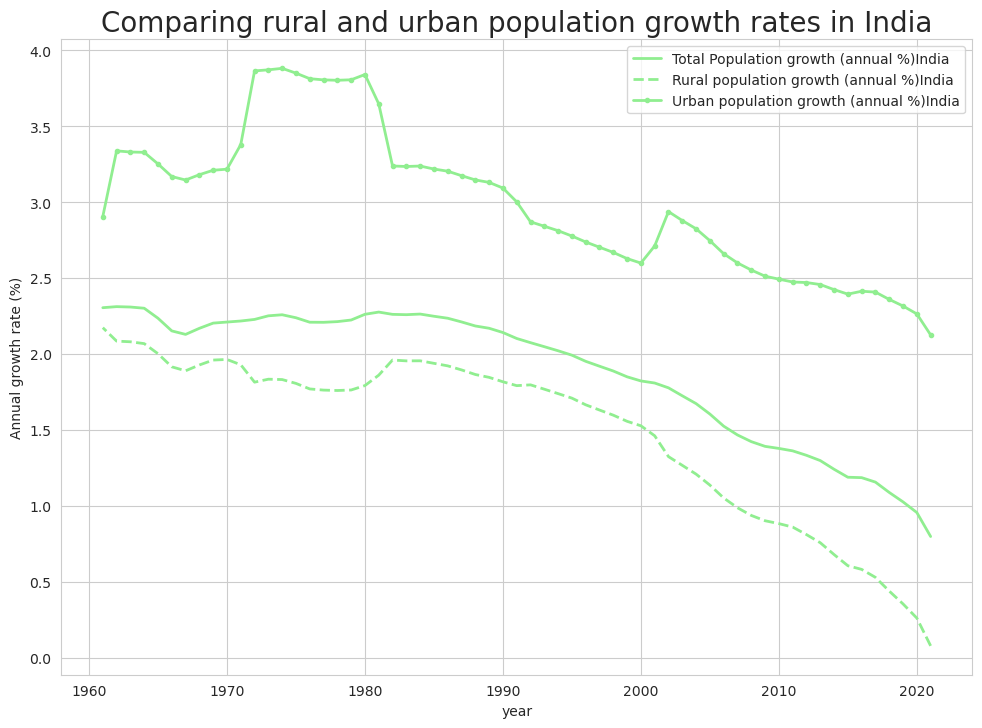

In [168]:
def urb_rur_plot(df, India, color):
    fig = plt.figure(figsize=(11.75, 8.25))
    ax = plt.axes() 
     
    plt.plot(ind_gr.index, ind_gr.iloc[:, 0],  color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 1],  '--', color='lightgreen',linewidth=2)
    plt.plot(ind_gr.index, ind_gr.iloc[:, 2],  '.-', color='lightgreen', linewidth=2);
    ax.legend((df.columns+India).append(ind_gr.columns))

    plt.title('Comparing rural and urban population growth rates in India', {'fontsize': 20})
    plt.xlabel('year')
    plt.ylabel('Annual growth rate (%)')

urb_rur_plot(ind_gr, "India", 'green')

In [169]:
IND_Birth_Death = wbdata.get_dataframe({'SP.DYN.CBRT.IN': 'Birth rate % (per 1,000 people)',
                            'SP.DYN.CDRT.IN': 'Death rate % (per 1,000 people)'}, country="IND")
                                       
IND_Birth_Death.index = IND_Birth_Death.index.rename('year')
IND_Birth_Death.index = IND_Birth_Death.index.astype(int)   

IND_Birth_Death.head(11)

,"Birth rate % (per 1,000 people)","Death rate % (per 1,000 people)"
year,,
2021,NaN,NaN
2020,16.572,7.350
2019,17.049,6.710
2018,17.651,6.644
2017,17.911,6.593
2016,18.514,6.603
2015,18.765,6.670
2014,19.049,6.790
2013,19.935,6.960


In [170]:
IND_Birth_Death.iplot(title="Population Growth in India",yTitle='Population',xTitle='Year')

In [178]:
!pip install iso3166
import iso3166 #iso3166.countries.get('country details')
def pop_df(year='2021', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df_helper(year, age_lower, age_upper, location)
        
    if group == 'males':
        return df.drop(columns = ['Female'])
    elif group == 'females':
        return df.drop(columns = ['Male'])
    else:
        total_pop = df["Female"] + df["Male"]
        df["Total"] = total_pop
    return df

# Returns a list of input strings for population age ranges
def pop_df_helper(year, age_lower, age_upper, location):
    if location != 'world':
        country_alpha3 = iso3166.countries.get(location).alpha3
        country_name = iso3166.countries.get(location).apolitical_name
    else:
        country_alpha3 = 'WLD'
        country_name = 'World'
    inputs = list_of_age_inputs(age_lower, age_upper)

    #create indicator-dictionaries required for WBData API
    indicator_dict_m = {}
    indicator_dict_f = {}
    for i in inputs:
        key_m = "SP.POP.{}.{}".format(i, 'MA')
        key_f = "SP.POP.{}.{}".format(i, 'FE')
        value = "{}-{}".format(i[:2], i[2:])
        indicator_dict_m[key_m] = value
        indicator_dict_f[key_f] = value

    #source_id = 40, refer to wbdata.get_source()
    wbdf_m = wbdata.get_dataframe(indicator_dict_m, country=country_alpha3, source=40)
    wbdf_f = wbdata.get_dataframe(indicator_dict_f, country=country_alpha3, source=40)
    datas_m = wbdf_m.query("date=='{}'".format(year)).sum(axis=0).tolist()
    datas_f = wbdf_f.query("date=='{}'".format(year)).sum(axis=0).tolist()
    df = pd.DataFrame({
        'Country': country_name,
        'Year': year,
        'Age': list(indicator_dict_m.values()),
        'Female': datas_f,
        'Male': datas_m
    })
    return df

# Returns a list of input strings for population age ranges
def list_of_age_inputs(age_lower, age_upper):
    def round_down(n):
        return max(0, n - n % 5)

    def round_up(n):
        return n - n % 5 + 5

    results = []
    r_lower_bound, r_upper_bound = round_down(age_lower), round_up(age_upper)   
    while r_lower_bound < min(79, r_upper_bound):
        results.append("{:02d}{:02d}".format(r_lower_bound, r_lower_bound + 4))
        r_lower_bound += 5
    if age_upper >= 80:
        results.append('80UP')
    return results

In [196]:
year = 2020 #1960 to 2050 (projections)
group = 'all' #males/females/all
age_lower = 0 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 100
location = 'India' #accepts country names/abbreviations, 'world'

In [197]:
df = pop_df(year, group, age_lower, age_upper, location)
df

,Country,Year,Age,Female,Male,Total
0,India,2020,00-04,55952175.0,60771735.0,116723910.0
1,India,2020,05-09,58262875.0,63921193.0,122184068.0
2,India,2020,10-14,59814870.0,65906417.0,125721287.0
3,India,2020,15-19,61362594.0,67689391.0,129051985.0
4,India,2020,20-24,59457333.0,65745248.0,125202581.0
5,India,2020,25-29,57184933.0,62448056.0,119632989.0
6,India,2020,30-34,54279610.0,58647559.0,112927169.0
7,India,2020,35-39,49403314.0,53259451.0,102662765.0
8,India,2020,40-44,43621841.0,46635684.0,90257525.0
9,India,2020,45-49,39150349.0,41235304.0,80385653.0


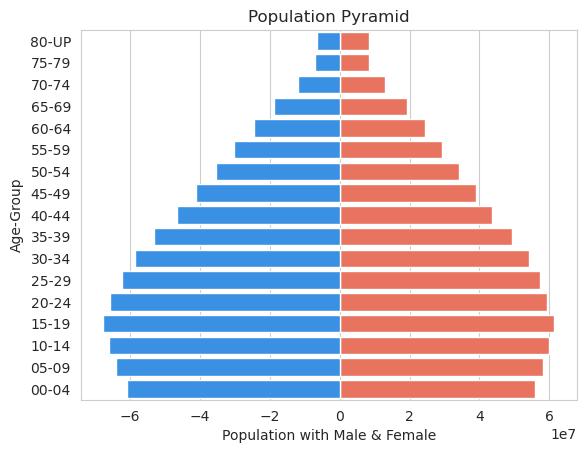

In [200]:
def pyramid(df):
    #negate values under 'Male'
    df['Male'] = df['Male'].apply(lambda x: -x)
    #remove unnecessary columns
    df.drop(columns = ['Country', 'Year', 'Total'])

    AgeClass = df['Age'][::-1]
    bar_plot = sns.barplot(x='Female', y='Age', color='tomato', label='Female Population',data=df, order=AgeClass)
    bar_plot = sns.barplot(x='Male', y='Age', color='dodgerblue', label='Male Population',data=df, order=AgeClass)
    bar_plot.set(xlabel="Population with Male & Female", ylabel="Age-Group", title = "Population Pyramid")

    year = 2020
    group = 'all'
    age_lower = 0
    age_upper = 100
    location = 'India'

df = pop_df(year, group, age_lower, age_upper, location)
pyramid(df) 